# Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random
import pickle
import pyarrow as pa

In [2]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn
!pip install xgboost


In [3]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import xgboost as xgb

In [4]:
# Load data from pickle files and convert to strings
# data_path = 'LZ Datasets/padded_waveforms.parquet'

files = [
    'SR1S2OAnalysis_Signal_SR3.pkl',
    'SR1S2OAnalysis_Gate_SR3.pkl',
    'SR1S2OAnalysis_Cathode_SR3.pkl',
]

tritium = pd.read_pickle('SR1S2OAnalysis_Signal_SR3.pkl')
gate = pd.read_pickle('SR1S2OAnalysis_Gate_SR3.pkl')
cathode = pd.read_pickle('SR1S2OAnalysis_Cathode_SR3.pkl')

# Add label columns
tritium['label'] = 2
gate['label'] = 1
cathode['label'] = 0

# print(df)
print(tritium.info())
print(gate.info())
print(cathode.info())

# Randomly sample 3500 rows from each DataFrame
# tritium_sample = tritium.sample(n=3500, random_state=42)
# gate_sample = gate.sample(n=3500, random_state=42)
# cathode_sample = cathode.sample(n=3500, random_state=42)

# Concatenate all samples into one large DataFrame
df = pd.concat([tritium, gate, cathode], ignore_index=True)
df['Volume'] = df['Volume'].astype(str) # Volume was initially a category dtype which Arrow converts to dictionary-encoded field whereby key is integer code name and definition is corresponding
# qualitative category. 

print(df.dtypes)

# Check the result
print(df.shape)
print(df.head())

# Conversion of combined df into awkward array for data processing, Starting with Awkward 2, the function ak.from_pandas no longer exists. 
# Instead, one common way to get a Pandas DataFrame into an Awkward Array is to go through PyArrow.
table = pa.Table.from_pandas(df)
arr = ak.from_arrow(table)

print(arr.fields) #analogous to df.columns.tolist()
print(tritium['scatterS2pArea'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339138 entries, 18 to 2572084
Data columns (total 63 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CX_HSX                 339138 non-null  int32   
 1   CX_MUONVETO            339138 non-null  int32   
 2   CX_ETV                 339138 non-null  int32   
 3   CX_S1RATE              339138 non-null  int32   
 4   CX_SUSTPHRATE          339138 non-null  int32   
 5   CX_S2LB                339138 non-null  int32   
 6   CX_S2UB                339138 non-null  int32   
 7   CX_FV                  339138 non-null  bool    
 8   CX_FCRES               339138 non-null  int32   
 9   CX_PROMINENTS2         339138 non-null  int32   
 10  CX_NARROWS2            339138 non-null  bool    
 11  CX_S2EARLYPEAK         339138 non-null  bool    
 12  CX_XYQUAL              339138 non-null  int32   
 13  CX_S2TBA               339138 non-null  bool    
 14  CX_BUFF           

   CX_HSX  CX_MUONVETO  CX_ETV  CX_S1RATE  CX_SUSTPHRATE  CX_S2LB  CX_S2UB  \
0       1            1       1          1              1        1        1   
1       1            1       1          1              1        1        1   
2       1            1       1          1              1        1        1   
3       1            1       0          1              1        1        1   
4       1            1       1          1              1        1        1   

   CX_FV  CX_FCRES  CX_PROMINENTS2  ...  badSumBaseline  Volume  scatterS2R2  \
0   True         1               1  ...       -2.909315       1  4264.377441   
1   True         1               1  ...       -0.667127       1   376.949860   
2   True         1               1  ...       -2.377520       1   923.986633   
3   True         1               1  ...       -8.430412       1  3861.629395   
4   True         1               1  ...       -3.681389       1  1561.587402   

   scatterWidth  scatterS2Rise  CX_S2RISETIME  pre

# Weighting the LE S2 Area Spectrum (Pt 1)

MAX areas: tritum,gate, cathode, overall dataset (3999.988, 3999.8213, 3999.8677, 3999.988)
68.37586388221153
68.37381 68.37586 68.37302
Total Number of Training Examples 420150


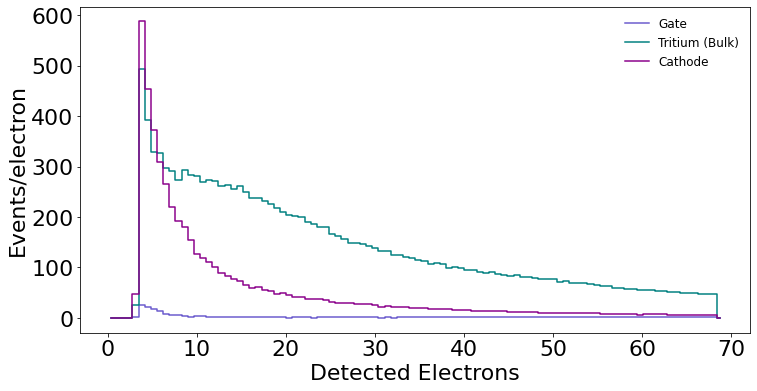

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

areas = arr['scatterS2pArea']
max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAX areas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].scatterS2pArea / electron_size
tritium_events = arr[(arr['label'] == 2)].scatterS2pArea / electron_size
cathode_events = arr[(arr['label'] == 0)].scatterS2pArea / electron_size

print(max(cathode_events), max(tritium_events), max(gate_events))

print(f'Total Number of Training Examples {len(arr["label"])}')
a = len(gate_events)
b = len(cathode_events)
c = len(tritium_events)

# Troubleshoot code to identify which sub-dataset has not had all its datapoints included in Hist object to clarify where miscount in total examples is sourced from.
# print(a)
# print(b)
# print(c)
# print(a+b+c)

"""
The correct order of operations should be:

1. Create the histogram (Hist object)

2. Fill the histogram with data (.fill())

3. Retrieve and adjust the counts (.view() / benchmark_value).

4. Plot the histogram.
"""
gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size * 1.01))
gate_hist.fill(gate_events)

### Calculation of bin edges to convert events to events/electron. as all Hist objects have identical bin ranges, calculating the params for gate hist only will suffice.
bin_edges = gate_hist.axes[0].edges  # Get bin edges from cathode histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
###

gate_counts = gate_hist.view() / bin_centers

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size * 1.01))
cathode_hist.fill(cathode_events)
# Retrieve and adjust counts for each histogram to produce a y-axis of events/electron
cathode_counts = cathode_hist.view() / bin_centers




tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size * 1.01))
tritium_hist.fill(tritium_events)
tritium_counts = tritium_hist.view() / bin_centers

ax.step(bin_centers, gate_counts, where='mid', color='slateblue', label='Gate')
ax.step(bin_centers, tritium_counts, where='mid', color='teal', label='Tritium (Bulk)')
ax.step(bin_centers, cathode_counts, where='mid', color='darkmagenta', label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=12) 
plt.savefig('LE_eventsperelectron.png', dpi=1800)
plt.show()

# Weighting the LE S2 Area Spectrum (Pt 2)

the cathode data 5127.970003058352
6355.949195484541
cathode reweighted last element 5127.970003058352
gate reweighted last element 246.4845910079295
tritium reweighted last element 13693.39299238734


<ipython-input-6-9bd2aab3b10e>:24: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
<ipython-input-6-9bd2aab3b10e>:30: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
<ipython-input-6-9bd2aab3b10e>:36: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
<ipython-input-6-9bd2aab3b10e>:49: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights / 20 # * (average_counts / gate_counts.sum())
<ipython-input-6-9bd2aab3b10e>:50: RuntimeWarning: invalid value encountered in multiply
  tritium_errors = np.sqrt(tritium_counts) * tritium_weights / 20 # * (average_counts / tritium_counts.sum())
<ipython-input-6-9bd2aab3b10e>:51: RuntimeWarn

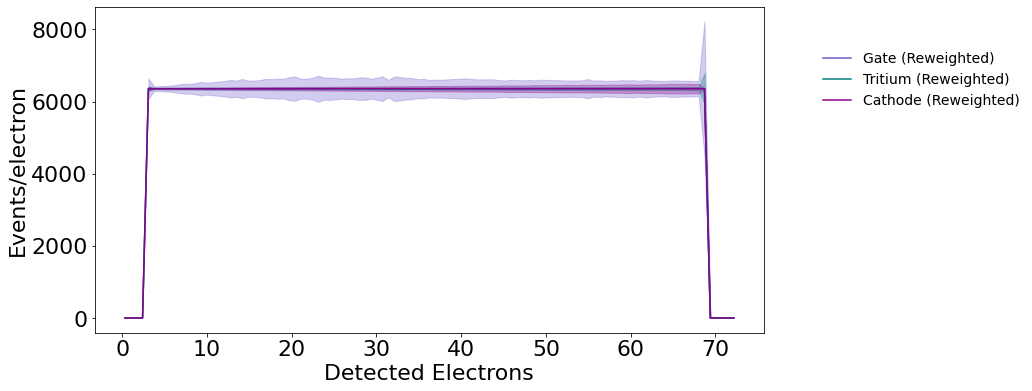

In [6]:
# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(f'the cathode data {cathode_counts.sum()}')

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()])
print(average_counts)

#for datapoint in range(0, len(gate_data)):
    #print(gate_data[datapoint])

#gate_reweighted = np.array([
    #gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0
    #for datapoint in range(len(gate_counts))
#])


gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] != 0 else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)
cathode_reweighted = np.array(cathode_reweighted)

#tritium_reweighted[-1] = 37.92238004

print(f'cathode reweighted last element {cathode_reweighted[-1]}')
print(f'gate reweighted last element {gate_reweighted[-1]}')
print(f'tritium reweighted last element {tritium_reweighted[-1]}')

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights / 20 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights / 20 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/ 20 # * (average_counts / cathode_counts.sum())

# Append zeros to start make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers (at end) by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

#ax.step(bin_centers, gate_reweighted * (average_counts/ gate_counts.sum()), where='mid', color='slateblue', label='Gate (Reweighted)')
#ax.step(bin_centers, tritium_reweighted * (average_counts/ tritium_counts.sum()), where='mid', color='teal', label='Tritium (Bulk, Reweighted)')
#ax.step(bin_centers, cathode_reweighted * (average_counts/ cathode_counts.sum()), where='mid', color='darkmagenta', label='Cathode (Reweighted)')


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.4,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('LE_weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating Weight Array to Feed into BDT

In [7]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)


#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

#print(gate_data)
#print(gate_weights)

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

# print(len(arr['weights'])) #check to ensure its same length as number of training examples
weight_column_4_mainarray = np.zeros(len(arr))

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with
# the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!
weights_np = ak.to_numpy(arr['weights'])

these are da 100
6254.0
339138.0
74758.0
420150
<class 'numpy.ndarray'>
420150
339138


# Created the Boosted Decision Tree (BDT) Model


In [8]:
# 1. Define the AFT column suffixes in ascending order
aft_suffixes = [1, 5, 10, 25, 50, 75, 90, 95, 99]

# 2. Create difference columns
#    For each adjacent pair (e.g., 1->5, 5->10, 10->25, etc.),
#    subtract the earlier from the later.
diff_col_names = []
for i in range(len(aft_suffixes) - 1):
    aft1 = aft_suffixes[i]
    aft2 = aft_suffixes[i+1]
    # print(aft1, aft2)
    
    # Name for the new difference column, e.g. "diffAFT1_5", "diffAFT5_10", ...
    col_name = f'diffAFT{aft1}_{aft2}'
    # print(col_name)
    
    # Compute the difference
    df[col_name] = df[f'scatterS2AFT{aft2}'] - df[f'scatterS2AFT{aft1}']
    
    diff_col_names.append(col_name)

# 3. Define the additional columns you want to include directly
other_cols = ['scatterS2fwhm', 'peakAmp', 'scatterS2TBA', 'scatterS2XYChi2', 'label']

# 4. Create the final DataFrame for BDT input
bdt_input = df[diff_col_names + other_cols]
print(bdt_input.columns)

# bdt_input now contains only the difference columns and the listed columns
print(bdt_input.head())


Index(['diffAFT1_5', 'diffAFT5_10', 'diffAFT10_25', 'diffAFT25_50',
       'diffAFT50_75', 'diffAFT75_90', 'diffAFT90_95', 'diffAFT95_99',
       'scatterS2fwhm', 'peakAmp', 'scatterS2TBA', 'scatterS2XYChi2', 'label'],
      dtype='object')
   diffAFT1_5  diffAFT5_10  diffAFT10_25  diffAFT25_50  diffAFT50_75  \
0         200          280           480           600           570   
1        2280          610           980          1240          1240   
2         370          210           380           500           560   
3         990          540           930          1000          1010   
4         740          340           700           860           840   

   diffAFT75_90  diffAFT90_95  diffAFT95_99  scatterS2fwhm   peakAmp  \
0           530           140           310           1430  0.353406   
1          1410           800          1280           4100  0.779994   
2           590           490          2040           1670  1.997792   
3          1080           750         

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Separate features and labels
X = bdt_input.drop(columns=["label"])
y = bdt_input["label"]

normalised_area = areas / electron_size  # converting 'area' to detected electrons by dividing by 58.5 
print(len(normalised_area))

# 2. Train-test split
X_train, X_test, y_train, y_test, weights_train, weights_test, area_train, area_test = train_test_split(
    X,
    y,
    weights_np,
    normalised_area,
    test_size=0.25,   # 25% for testing
    random_state=42,
    stratify=y
)

print(len(area_test), len(y_test))

# 3. Convert to xgboost's DMatrix format (recommended for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 4. Define training parameters
#    We'll do a simple parameter set; will tune later.
params = {
    "objective": "multi:softprob",  # multi-class classification with predicted probabilities for each class
    "num_class": 3,               # we have classes 0, 1, 2
    "eval_metric": "mlogloss",    # or "merror", "mlogloss" etc.
    "eta": 0.1,                   # learning rate
    "max_depth": 6,               # depth of each tree
    "seed": 42
}

# 5. Train the XGBoost model
evals_result = {}  # store evaluation results
evallist = [(dtrain, "train"), (dtest, "eval")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,   # number of boosting rounds
    evals=evallist,
    evals_result=evals_result,
    verbose_eval=False # set to True if you want iterative feedback
)

# 6. Make predictions
y_pred_proba = bst.predict(dtest)  # for "multi:softmax", returns class labels directly

# 7. Evaluate
y_pred = np.argmax(y_pred_proba, axis = 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))



420150
105038 105038
Confusion Matrix:
[[15968     5  2717]
 [   19   754   790]
 [13534   164 71087]]

Classification Report:
              precision    recall  f1-score   support

           0      0.541     0.854     0.662     18690
           1      0.817     0.482     0.607      1563
           2      0.953     0.838     0.892     84785

    accuracy                          0.836    105038
   macro avg      0.770     0.725     0.720    105038
weighted avg      0.878     0.836     0.847    105038



## BDT Hyperparameter Tuning

In [10]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import load_iris
# from xgboost import XGBClassifier

# # Define the XGBoost classifier
# xgb_clf = XGBClassifier(use_label_encoder=False, objective="multi:softmax", num_class=3, random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5, 6],
# }

# # Grid search
# grid = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=1)
# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_) # Calculated via a cross-validation (gridsearch) approach.r

# Creating the ROC Curves

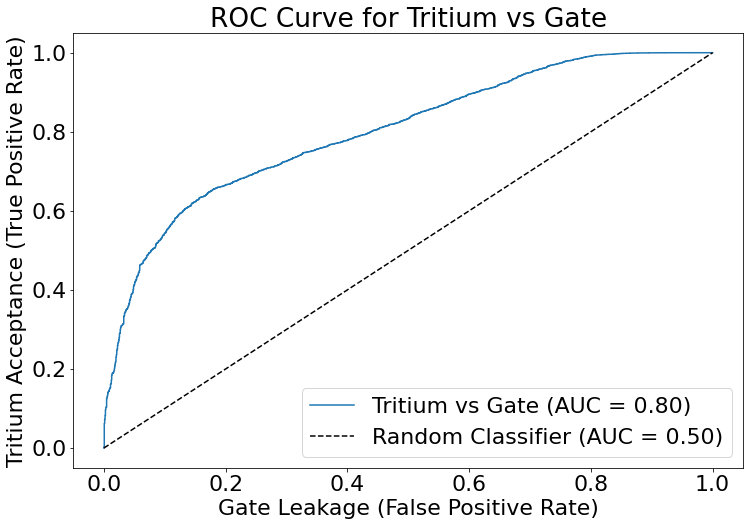

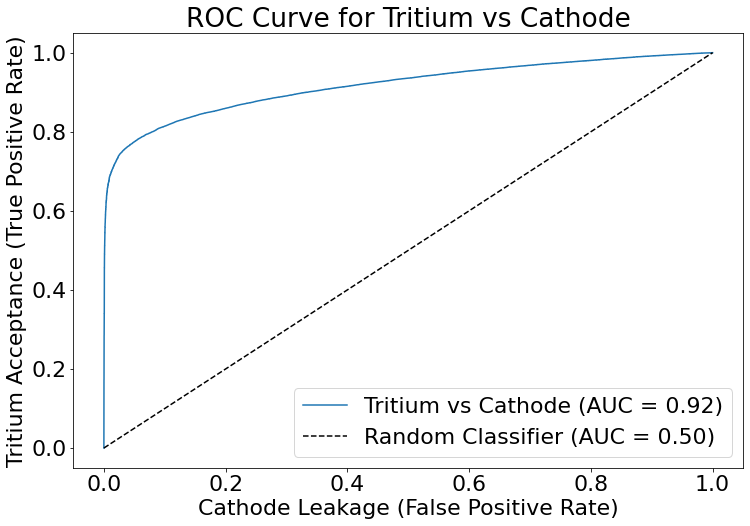

'\nKey Changes from CNN ROC code:\n\n1. Objective Function: Changed from multi:softmax to multi:softprob to get class probabilities.\n\n2. Prediction: Used y_pred_proba to store the predicted probabilities for each class.\n\n3. ROC Curve Calculation: Used the predicted probabilities for the Tritium class (class 2) to compute the ROC curves for the binary classification tasks.\n\n'

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.legend(loc='lower right')
plt.savefig('BDTROC_TRITUMVGATE.png')
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.legend(loc='lower right')
plt.savefig('BDTROC_TRITUMVCATHODE.png')
plt.show()

"""
Key Changes from CNN ROC code:

1. Objective Function: Changed from multi:softmax to multi:softprob to get class probabilities.

2. Prediction: Used y_pred_proba to store the predicted probabilities for each class.

3. ROC Curve Calculation: Used the predicted probabilities for the Tritium class (class 2) to compute the ROC curves for the binary classification tasks.

"""


# Visualising BDT Classification Effectiveness: The Probability Distribution

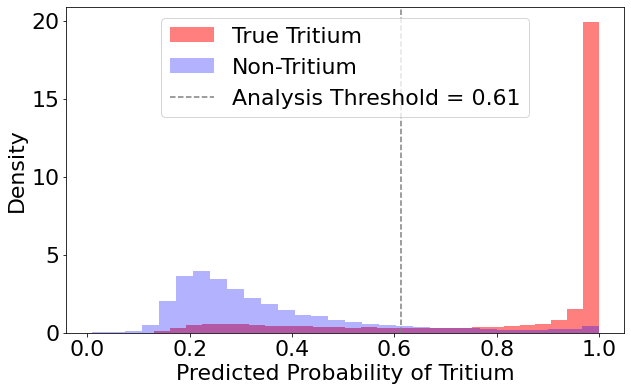

In [12]:
predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
# for i in range(30):
    # print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities. All the training examples in the training dataset that the model has predicted to be tritium.

# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2) # actual tritium (signal) events
non_tritium_mask = (y_test != 2) # non-tritium (background) events

threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.axvline(x=threshold, color='gray', linestyle='--', label=f'Analysis Threshold = {threshold:.2f}')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.savefig('BDTprobdensity.png')
plt.show()

[ 3.41915727 16.41045704 29.40175681 42.39305658 55.38435636 68.37565613]
y_test_np shape: (105038,)
area_test_np shape: (105038,)


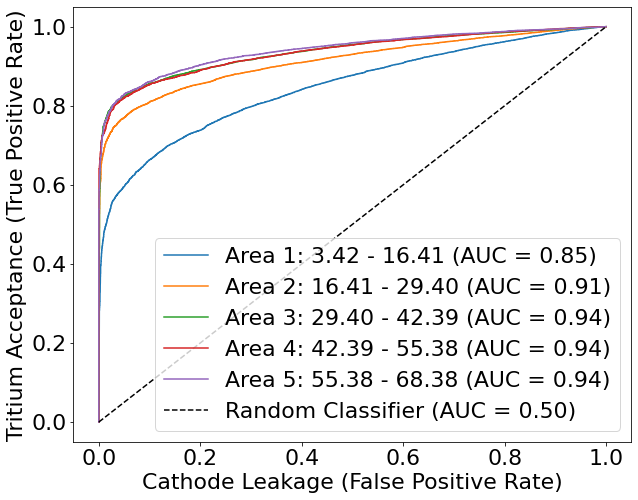

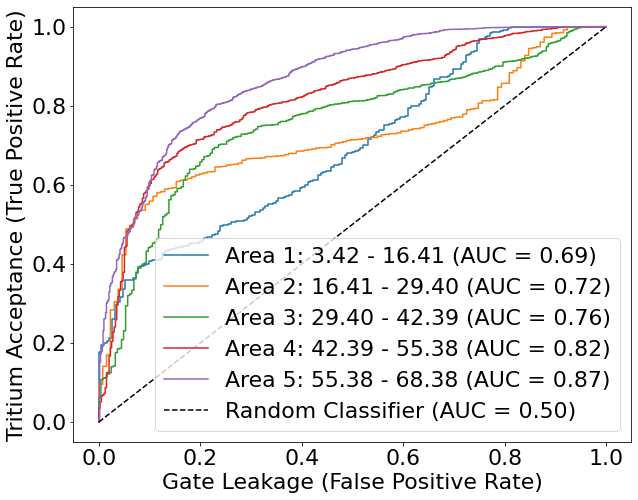

In [13]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.savefig(f'BDTtritiumvs{event_type}.png')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


## Figure 7 (LUX-LOWMASS) Production

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.613


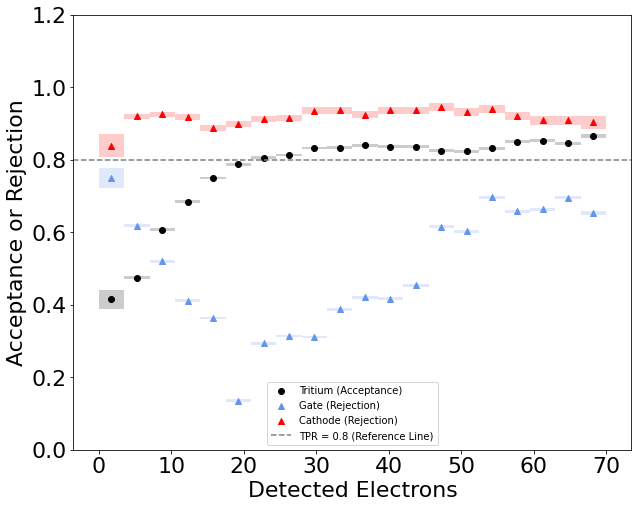

In [14]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(0, 70, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalize by true Tritium count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count
            error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(10, 8))

# Plot Tritium acceptance points with error bars
for x, y, error in zip(tritium_x, tritium_y, tritium_error):
    plt.scatter(x, y, color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection points with error bars
for x, y, error in zip(gate_x, gate_y, gate_error):
    plt.scatter(x, y, color='cornflowerblue', marker='^', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='cornflowerblue', alpha=0.2, linewidth=0)

# Plot Cathode rejection points with error bars
for x, y, error in zip(cathode_x, cathode_y, cathode_error):
    plt.scatter(x, y, color='red', marker='^', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_betweenx([y - error,1, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='red', alpha=0.2, linewidth=0)


plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons")
plt.ylabel("Acceptance or Rejection")
plt.legend(loc='lower center', fontsize=10)
plt.savefig('BDTLEFig7.png')
plt.show()




# Random Forest

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


# 1. Separate features and labels
X = bdt_input.drop(columns=["label"])
y = bdt_input["label"]

normalised_area = areas / electron_size  # converting 'area' to detected electrons by dividing by 58.5 
print(len(normalised_area))

# 2. Train-test split
X_train, X_test, y_train, y_test, weights_train, weights_test, area_train, area_test = train_test_split(
    X,
    y,
    weights_np,
    normalised_area,
    test_size=0.25,   # 25% for testing
    random_state=42,
    stratify=y
)

print(len(area_test), len(y_test))

# 3. Convert to xgboost's DMatrix format (recommended for efficiency)
#dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
#dtest = xgb.DMatrix(X_test, label=y_test)


# Step 7: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

420150
105038 105038
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61     18690
           1       0.80      0.53      0.63      1563
           2       0.90      0.92      0.91     84785

    accuracy                           0.85    105038
   macro avg       0.77      0.68      0.72    105038
weighted avg       0.85      0.85      0.85    105038

Confusion Matrix:
[[11144     2  7544]
 [   12   823   728]
 [ 6817   208 77760]]


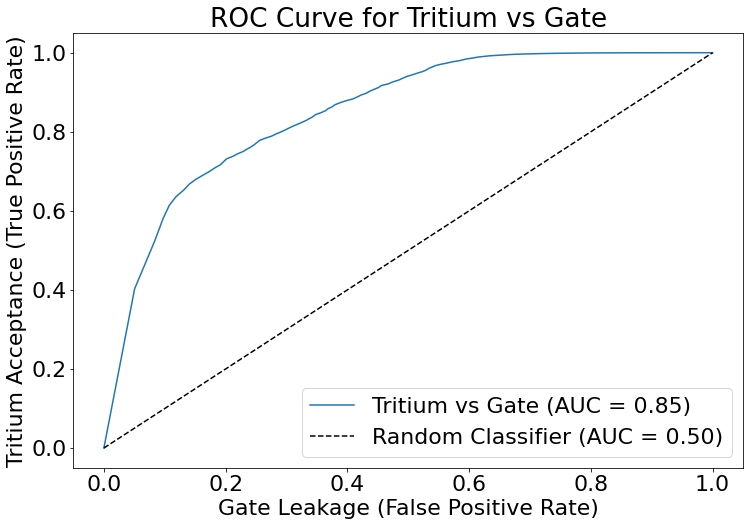

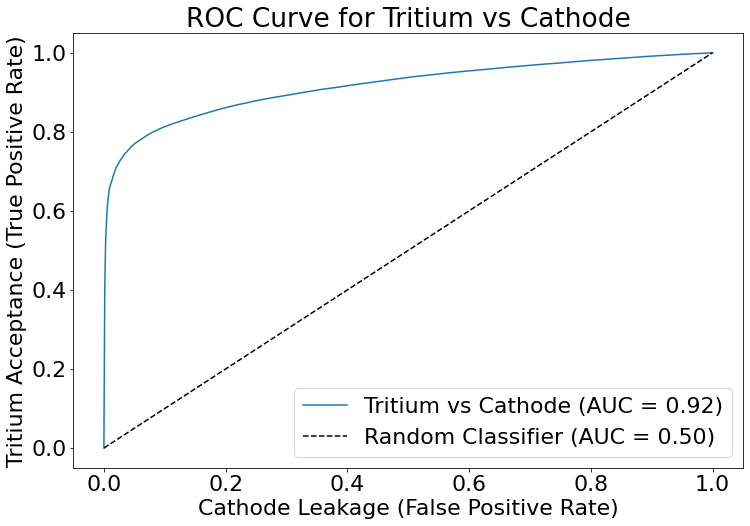

'\nKey Changes from CNN ROC code:\n\n1. Objective Function: Changed from multi:softmax to multi:softprob to get class probabilities.\n\n2. Prediction: Used y_pred_proba to store the predicted probabilities for each class.\n\n3. ROC Curve Calculation: Used the predicted probabilities for the Tritium class (class 2) to compute the ROC curves for the binary classification tasks.\n\n'

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
y_pred_proba = rf_model.predict_proba(X_test)
# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.legend(loc='lower right')
plt.savefig('BDTROC_TRITUMVGATE.png')
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.legend(loc='lower right')
plt.savefig('RFROC_TRITUMVCATHODE.png')
plt.show()

"""
Key Changes from CNN ROC code:

1. Objective Function: Changed from multi:softmax to multi:softprob to get class probabilities.

2. Prediction: Used y_pred_proba to store the predicted probabilities for each class.

3. ROC Curve Calculation: Used the predicted probabilities for the Tritium class (class 2) to compute the ROC curves for the binary classification tasks.

"""

# VisualisingRF Classification Effectiveness: The Probability Distribution

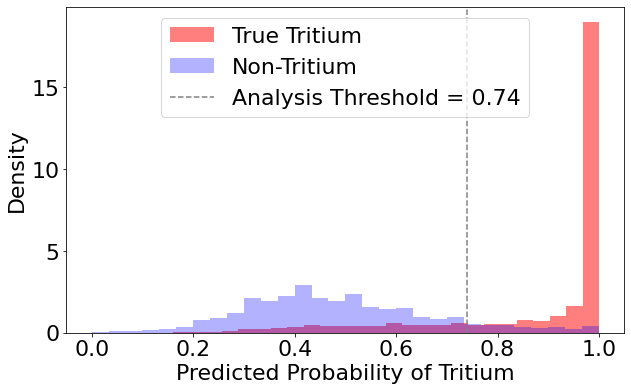

In [17]:
predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
# for i in range(30):
    # print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities. All the training examples in the training dataset that the model has predicted to be tritium.

# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2) # actual tritium (signal) events
non_tritium_mask = (y_test != 2) # non-tritium (background) events

threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.axvline(x=threshold, color='gray', linestyle='--', label=f'Analysis Threshold = {threshold:.2f}')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.savefig('RFprobdensity.png')
plt.show()

[ 3.41915727 16.41045704 29.40175681 42.39305658 55.38435636 68.37565613]
y_test_np shape: (105038,)
area_test_np shape: (105038,)


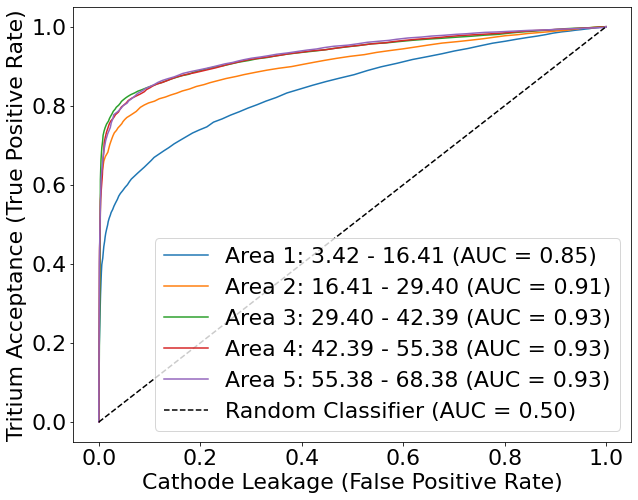

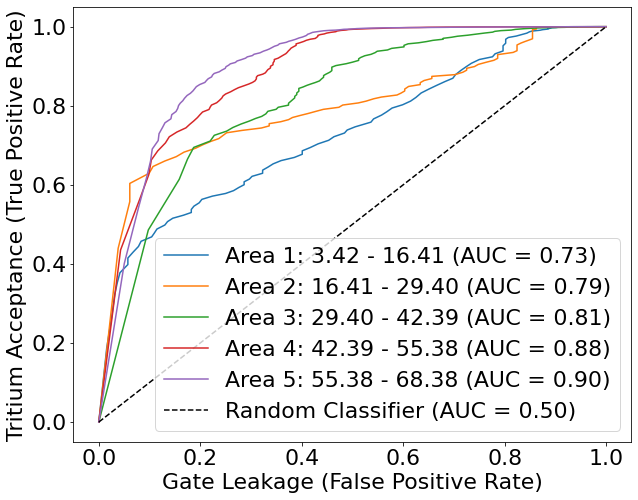

In [18]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.savefig(f'RFtritiumvs{event_type}.png')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


# Figure 7 LUX(LOW-MASS) Production

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.740


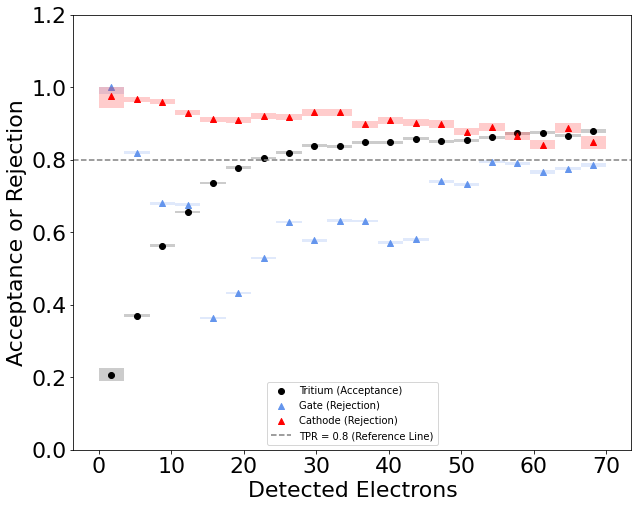

In [19]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(0, 70, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalize by true Tritium count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count
            error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(10, 8))

# Plot Tritium acceptance points with error bars
for x, y, error in zip(tritium_x, tritium_y, tritium_error):
    plt.scatter(x, y, color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection points with error bars
for x, y, error in zip(gate_x, gate_y, gate_error):
    plt.scatter(x, y, color='cornflowerblue', marker='^', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='cornflowerblue', alpha=0.2, linewidth=0)

# Plot Cathode rejection points with error bars
for x, y, error in zip(cathode_x, cathode_y, cathode_error):
    plt.scatter(x, y, color='red', marker='^', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_betweenx([y - error,1, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='red', alpha=0.2, linewidth=0)


plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons")
plt.ylabel("Acceptance or Rejection")
plt.legend(loc='lower center', fontsize=10)
plt.savefig('RFLEFig7.png')
plt.show()
